# Analyze A/B Test Results 


- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. We will be working to understand the results of an A/B test run by an e-commerce website through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

**We will use 3 methods: Probability based approach, Hypothesis Testing, and Logistic Regression.**

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### 1. 

In [2]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


**b.** Find the number of rows in the dataset.

In [4]:
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [5]:
df.user_id.nunique()

290584

In [6]:
df.user_id.unique()

array([851104, 804228, 661590, ..., 734608, 697314, 715931], dtype=int64)

**d.** The proportion of users converted.

In [8]:
df.converted.mean()

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [9]:
df.query("group == 'treatment' and landing_page !='new_page' ").count()[0]

1965

**f.** Do any of the rows have missing values?

In [11]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


In [12]:
##### Remove the inaccurate rows, and store the result in a new dataframe df2
indexcontrol = df[ (df['group'] == "control") & (df['landing_page'] != 'old_page') ].index
indextreatment = df[ (df['group'] == "treatment") & (df['landing_page'] != 'new_page') ].index
df2 = df.drop(indexcontrol).drop(indextreatment)
#df2 = df.drop(df[((df['group'] == 'control') and (df['landing_page'] != 'old_page')) ordf[((df['group'] == 'treatment') and (df['landing_page'] != 'new_page')) ])

In [13]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [14]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [15]:
df2.shape[0]

290585

### 2

**a.** How many unique **user_id**s are in **df2**?

In [16]:
df2.user_id.nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [19]:
df2.user_id.value_counts().head(1)

773192    2
Name: user_id, dtype: int64

**c.** Display the rows for the duplicate **user_id**? 

In [20]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [21]:
idx=df2[df2['user_id'] == 773192].index[1]
df2.iloc[idx]

user_id                             673693
timestamp       2017-01-22 07:32:26.184894
group                            treatment
landing_page                      new_page
converted                                0
Name: 2924, dtype: object

In [22]:
# Remove one of the rows with a duplicate user_id..
df2.drop(idx , inplace=True)
# Check again if the row with a duplicate user_id is deleted or not
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


### 3 

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>


In [24]:
df2.converted.mean()

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [25]:
ctr_converted = df2.query('group == "control"').converted.sum()/df2.query('group == "control"').converted.count()
ctr_converted

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [26]:
treat_converted = df2.query('group == "treatment"').converted.sum()/df2.query('group == "treatment"').converted.count()
treat_converted

0.11880806551510564

In [27]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = treat_converted - ctr_converted 
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [28]:
df2.query('landing_page == "new_page"').count()[0]/df2.shape[0]

0.5000619442226688

>**Considering our results from parts (a) through (d) above and with this probability based approach, we find that the new page has a slightly lower converstion rate than the old page!**

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, we could run a hypothesis test continuously as long as we observe the events. 

However, then the hard questions would be: 
- Do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


For now, consider we need to make the decision just based on all the data provided.  

> Recall that we just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page

If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, our null and alternative hypotheses (**$H_0$** and **$H_1$**) should be:  

**$p_{old}$** and **$p_{new}$** are the "converted" probability (or rate) for the old and new pages respectively.

**$H_0$** : *$p_{new}$* - **$p_{old}$** <= 0

**$H_1$** :*$p_{new}$* - **$p_{old}$** > 0

### Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, we will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 


**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [29]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [30]:
p_old= df2.converted.mean()
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>

In [31]:
n_new = df2.query('landing_page == "new_page"').shape[0]
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [32]:
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old

145274

**e. Sample Simulation for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>

In [33]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0, 1], size=n_new, p=[p_new, 1-p_new])
new_page_converted

array([1, 1, 1, ..., 1, 1, 1])

**f. Sample Simulation for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [34]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0, 1], size=n_old, p=[p_old, 1-p_old])
old_page_converted

array([0, 1, 1, ..., 1, 1, 1])

**g.** Finding the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [35]:
difference = new_page_converted.mean() - old_page_converted.mean()
difference

0.002101250209373462


**h. Sampling distribution** <br>
Re-creating `new_page_converted` and `old_page_converted` and finding the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process we used in parts (a) through (g) above. 

<br>
We will store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [62]:
# Sampling distribution 
new_converted_simulation = np.random.binomial(n_new, p_new,  10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old,  10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

**i. Histogram**<br> 

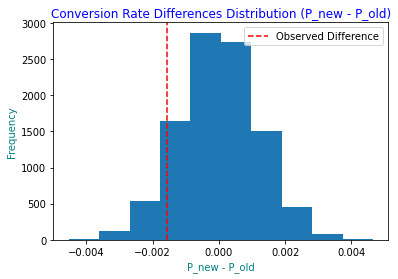

In [63]:
plt.hist(p_diffs);
plt.axvline(x=obs_diff, color='red', linestyle='--', label='Observed Difference');
plt.xlabel('P_new - P_old', color='teal', size=10)
plt.ylabel('Frequency', color='teal', size=10)
plt.title('Conversion Rate Differences Distribution (P_new - P_old)', color='blue', size=12)
plt.legend();
plt.show();

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [69]:
(p_diffs > obs_diff).mean()

0.9043

> - **The value we calculated is called the p-value, it is the probability of observing our statistic or a more extreme value in favor of the alternative) if the null hypothesis is true.**

> - **Comparing the p-value to the Type I error rate, a small p-value suggest our null is not true. Rather, our statistic is likely to have come from a different distribution than the null.
When the p-value is large, we have evidence that our statistic was likely to come from the null hypothesis. Therefore, we do not have evidence to reject the null.**

> - **By comparing our p-value to our type I error threshold α, we found that it is larger, so we fail to reject the null hypothesis**



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results. 

- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [39]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('group == "control"').converted.sum()

# number of conversions with the new_page
convert_new = df2.query('group == "treatment"').converted.sum()

# number of individuals who were shown the old_page
n_old = df2.query('landing_page == "old_page"').shape[0]

# number of individuals who received new_page
n_new = df2.query('landing_page == "new_page"').shape[0]

**m.** Now we use `sm.stats.proportions_ztest()` to compute our  test statistic and p-value.  ([Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.)

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 

The built-in function above will return the z_score, p_value. 

In [41]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_new,convert_old], [n_new,n_old], alternative='larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


**n.** What do the z-score and p-value we computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

**we found that our $Z_{score}$(-1.31) < $Z_{0.05}$ (1.645 for one-tailed tests) which indicates that we fail to reject the null hypothesis here. Furthermore, the obtained p-value here is similar to the one we found in parts j. and k.**

**Both methods indicated that we fail to reject the null hypothesis, where we have evidence that the old page performed slightly better than the new page.**


<a id='regression'></a>
### Part III - A regression approach

In this final part, we will see that the results we achieved in the A/B test above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, We should perform a Logistic Regression.

**b.** The goal is to use **statsmodels** library to fit the regression model we specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, we first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [46]:
df2["intercept"] = 1
df2[['control','treatment']]= pd.get_dummies(df2['group'])
df2 = df2.drop('control',axis = 1)
df2.rename(columns={'treatment': 'ab_page'},inplace=True)
df2.head()


,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


**c.** Using **statsmodels** to instantiate our regression model on the two columns we created in part (b). above, then we fit the model to predict whether or not an individual converts. 


In [47]:
#instantiate logistic regression model
logit_mod =sm.Logit(df2['converted'],df2[['intercept', 'ab_page']])

**d.** Provide the summary of our model below, and using it as necessary to answer the following questions.

In [48]:
#fit the model
results = logit_mod.fit()

#get summary statistics
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-11-04 16:33 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**the p-value associated with ab_page differs from the value you found in Part II (but it comes to the same conclusion in the end) because of the following:**

>**1- In logistic regression, we define the null and alternative hypotheses as follows:**

   >**$H_0$** : *$p_{new}$* - **$p_{old}$** = 0
   
   >**$H_1$** :*$p_{new}$* - **$p_{old}$** $\neq$ 0

   > ***which is different from what we defined in part II.***

>**2- The logistic regression is two-sided unlike what we used in part II which was one-sided.**

>**3- Comparing the current p-value (0.1899) with the Type I error rate (0.05) we find that it's larger that our threshold, which provide sufficant evidence that we fail to reject the null hypothesis, meaning here that the old and new page performances are similar.**


**f.** Now, we are considering other things that might influence whether or not an individual converts. 

In [49]:
# Duration of the expiremnt 
df2["timestamp"] = pd.to_datetime(df2.timestamp)
df2.timestamp.max()-df2.timestamp.min()

Timedelta('21 days 23:59:49.081927')

>**Adding other factors into our regression model would prove valuable, it may reveal hidden aspects and reasons to whether the user converts or not, or to adress more problems that hinders users from converting, like the page language, country/region or spoken language, age, gender ..etc, we also can extend the duration of the expiremnt, 22 days is somehow a short time(Change aversion and Novelty effect problems).**

>**The disadvantage of adding more factors, is that we may add some complexity to our model, we might fave some problems with the factors being correlated to each other, or even something like the Simpson's paradox**

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also we will add an effect based on which country a user lives in. 

1. we will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. we call the resulting dataframe `df_merged`.

2. Does it appear that country had an impact on conversion?  To answer this question, we consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. then we will create dummy variables for these country columns. 

In [50]:
# Read the countries.csv
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [51]:
# Join with the df2 dataframe
df_merged = df2.join(df_countries.set_index('user_id'),on ='user_id')
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [52]:
#checking what countries are available in our data
df_merged.country.unique()

array(['US', 'CA', 'UK'], dtype=object)

In [54]:
# Create the necessary dummy variables
df_merged[['CA', 'UK', 'US']] = pd.get_dummies(df_merged['country'])
df_merged.sample(5)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
214239,905762,2017-01-11 21:59:40.534511,control,old_page,0,1,0,UK,0,1,0
284983,734207,2017-01-20 22:11:44.082834,control,old_page,0,1,0,US,0,0,1
64099,934222,2017-01-05 14:48:01.273791,control,old_page,0,1,0,CA,1,0,0
46886,703246,2017-01-15 08:23:02.703803,treatment,new_page,0,1,1,US,0,0,1
183048,910437,2017-01-21 02:21:00.657664,control,old_page,1,1,0,US,0,0,1


**h. Fit our model and obtain the results**<br> 
Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there are significant effects on conversion.  

In [67]:
# Fit your model, and summarize the results
# Setting US as our baseline
df_merged['ab_UK'] = df_merged['ab_page'] * df_merged['UK']
df_merged['ab_US'] = df_merged['ab_page'] * df_merged['US']
lm3 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK' , 'US', 'ab_UK', 'ab_US']])
results2 = lm3.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 04 Nov 2022   Pseudo R-squ.:               3.482e-05
Time:                        17:12:03   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
ab_UK          0.0783      0.057      1.378      0.168      -0.033       0.190
ab_US          0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

In [68]:
# exp and 1/exp of the coefficients:
np.exp(results2.params[0]),1/np.exp(results2.params[1:])

(0.13479426139050874,
 ab_page    1.069775
 UK         0.988285
 US         0.982625
 ab_UK      0.924703
 ab_US      0.954198
 dtype: float64)

**wee see no variable here with a p-value below 0.05, so adding countries into our regression model doesn't provide us with practical significance.**

## Conclusion
Based on the performed A/B test, using three different methods(Probability, Hypothesis Testing, and Logistic Regression), by looking at the information available to us, we found evidence that our old page performed slighly better than the new one, and there is no evident advantages in implementing the new page.


In [59]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results.ipynb'])

1